In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import execute, Aer, BasicAer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from resizeimage import resizeimage
import warnings
warnings.filterwarnings('ignore')
from qiskit.aqua.circuits.fourier_transform_circuits import FourierTransformCircuits
from scipy import misc
from matplotlib.image import imread

In [2]:
import frqi                                                                     
import quantum_edge_detection as qed

Using TensorFlow backend.


In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-university", group="columbia-univers", project="comse-6998-2020")

In [4]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [5]:
# Function to perform reflection along a line passing through the origin with slope 1
def swap_x_y(circ, img):
    lencirc = int(len(img)/2)
    start = 1
    end = start + lencirc
    for x in range(1, end):
        circ.swap(img[x], img[x+lencirc])
    return circ

In [6]:
# Helper function to setup x rotations between necessary position bits
def flip(circ, img, start):
    end = start + int(len(img)/2)
    for i in range(start, end):
        circ.x(img[i])
    return circ

# Function to perform reflection along the x-axis
def flip_x(circ, img):
    start = 1 + int(len(img)/2)
    return flip(circ, img, start)

# Function to perform reflection along the y-axis
def flip_y(circ, img):
    start = 1
    return flip(circ, img, start)

In [7]:
#Function to perform rotation of image by 90 degrees anti-clockwise
def r90(circ, img):
    return swap_x_y(flip_y(circ, img), img)

#Function to perform rotation of image by 180 degrees
def r180(circ, img):
    return flip_x(flip_y(circ, img), img)

#Function to perform rotation of image by 270 degrees anti-clockwise
def r270(circ, img):
    return swap_x_y(flip_x(circ, img), img)

In [8]:
#Flip Color intensity
def color_flip(circ, img):
    circ.x(img[0])
    return circ

#Function to darken upper half of the image
def rotation_color_angle(circ, img, angle):
    imglen = len(img)
    circ.mcry(angle, [img[j] for j in [4,5,6,7,8,9,10]], img[0], None, mode='noancilla')
    circ.mcry(angle/2, [img[j] for j in [1,2,3,6,7,8,9,10]], img[0], None, mode='noancilla')
    return circ

#Function to darken a specific blob in the image
def trial_color_angle(circ, img, angle):
    imglen = len(img)
    circ.mcry(angle, [img[j] for j in [1,2,3,6,7,8]], img[0], None, mode='noancilla')
    return circ

In [9]:
# Convert black and white images to encodable form
def image_normalization(image):
    image = resizeimage.resize_cover(image, [32, 32])
    w, h = 32, 32
    image = np.array([[image.getpixel((x,y))[0] for x in range(w)] for y in range(h)])

    # 2-dimentional data convert to 1-dimentional array
    image = image.flatten()
    # change type
    image = image.astype('float64')
    # Normalization(0~pi/2)
    image /= 255.0
    generated_image = np.arcsin(image)

    return generated_image

# Convert color images to encodable form
def image_normalization_col(image):
    image = image.resize((32,32),resample=Image.NEAREST)
    px = image.load()
    w, h = 32, 32
    imagea = np.zeros((32,32)) + 1
    imager = np.array([[image.getpixel((x,y))[0] for x in range(w)] for y in range(h)])
    imageg = np.array([[image.getpixel((x,y))[1] for x in range(w)] for y in range(h)])
    imageb = np.array([[image.getpixel((x,y))[2] for x in range(w)] for y in range(h)])

    # 2-dimentional data convert to 1-dimentional array
    imagea = imagea.flatten()
    imager = imager.flatten()
    imageg = imageg.flatten()
    imageb = imageb.flatten()
    
    # change type
    
    imagea = imagea.astype('float64')
    imager = imager.astype('float64')
    imageg = imageg.astype('float64')
    imageb = imageb.astype('float64')
    # Normalization(0~pi/2)
    imager /= 255.0
    imageg /= 255.0
    imageb /= 255.0
    
    generated_imager = np.arcsin(imagea)
    generated_imager = np.arcsin(imager)
    generated_imageg = np.arcsin(imageg)
    generated_imageb = np.arcsin(imageb)

    return np.concatenate((imagea, imager, imageg, imageb), axis=None)

In [10]:
def enc_img_bw(image):
    anc_bw = QuantumRegister(1, "anc_bw")
    img_bw = QuantumRegister(11, "img_bw")
    anc2_bw = QuantumRegister(1, "anc2_bw")
    c_bw = ClassicalRegister(12)
    qc = QuantumCircuit(anc_bw, img_bw, anc2_bw,c_bw)
    
    for i in range(1, len(img_bw)):
        qc.h(img_bw[i])
    for i in range(len(image)):
        if image[i] != 0:
                frqi.c10mary(qc, 2 * image[i], format(i, '010b'), img_bw[0], anc2_bw[0], [img_bw[j] for j in range(1,len(img_bw))])
    return (anc_bw, img_bw, anc2_bw, c_bw, qc)
    

In [43]:
def enc_img_col(image):
    anc_col = QuantumRegister(1, "anc_col")
    img_col = QuantumRegister(14, "img_col")
    anc2_col = QuantumRegister(4, "anc2_col")
    c_col = ClassicalRegister(15)
    qc_col = QuantumCircuit(anc_col, img_col, anc2_col,c_col)
    
    for i in range(4, len(img_col)):
        qc_col.h(img_col[i])
    
    imlen = int(len(image)/4)
    
    offseta = 0
    offsetr = imlen
    offsetg = imlen * 2
    offsetb = imlen * 3
    
    for i in range(imlen):
        if image[i+offseta] != 0:
                frqi.c10mary(qc_col, 2 * image[i+offseta], format(i, '010b'), img_col[0], anc2_col[0], [img_col[j] for j in range(4,len(img_col))])
        if image[i+offsetr] != 0:
                frqi.c10mary(qc_col, 2 * image[i+offsetr], format(i, '010b'), img_col[1], anc2_col[1], [img_col[j] for j in range(4,len(img_col))])
        if image[i+offsetg] != 0:
                frqi.c10mary(qc_col, 2 * image[i+offsetg], format(i, '010b'), img_col[2], anc2_col[2], [img_col[j] for j in range(4,len(img_col))])
        if image[i+offsetb] != 0:
                frqi.c10mary(qc_col, 2 * image[i+offsetb], format(i, '010b'), img_col[3], anc2_col[3], [img_col[j] for j in range(4,len(img_col))])
 
    return (anc_col, img_col, anc2_col, c_col, qc_col) 

In [12]:
def enc_img_bw_mod(image, op=1):
    (anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw(image)
    
    if op==1:
        qc = qc
    elif op==2:
        swap_x_y(qc, img_bw)
    elif op == 3:
        flip_x(qc, img_bw)
    elif op == 4:
        flip_y(qc, img_bw)
    elif op == 5:
        r90(qc, img_bw)
    elif op == 6:
        r180(qc, img_bw)
    elif op == 7:
        r270(qc, img_bw)
    elif op == 8:
        color_flip(qc, img_bw)
    elif op == 9:
        rotation_color_angle(qc, img_bw, (2*np.pi/3))
    elif op == 10:
        trial_color_angle(qc, img_bw, (np.pi/12.5))
    elif op == 11:
        qed.quantum_edge_detection(qc)
    elif op == 12:
        FourierTransformCircuits.construct_circuit(qc, img_bw)
    else:
        qc = qc
    
    qc.measure(anc_bw, c_bw[0])
    qc.measure(img_bw, c_bw[1:12])
    
    retval = (anc_bw, img_bw, anc2_bw, c_bw, qc)
    
    return retval

In [44]:
def enc_img_col_mod(image, op=1):
    (anc_col, img_col, anc2_col, c_col, qc_col) = enc_img_col(image)
    if op == 1:
        qc_col = qc_col
    else:
        qc_col = qc_col
    qc_col.measure(anc_col, c_col[0])
    qc_col.measure(img_col, c_col[1:15])
    
    retval = (anc_col, img_col, anc2_col, c_col, qc_col)
    
    return retval

In [21]:
def decode_image_bw(result, qc, shots, w, h):
    genimg = np.array([])
    sz = w*h
    for i in range(sz):
        try:
                genimg = np.append(genimg,[np.sqrt(result.get_counts(qc)[format(i, '010b')+'10']/shots)])
        except KeyError:
                genimg = np.append(genimg,[0.0])
    genimg *= 32.0 * 255.0
    genimg = genimg.astype('int')
    genimg = genimg.reshape((w,h))
    return genimg

In [47]:
def decode_image_col(result, qc_col, shots, w, h):
    genimg_col = np.array([])
    sz = w*h
    
    for i in range(sz):
        try:
                genimg_col = np.append(genimg_col,[np.sqrt(result_col.get_counts(qc_col)[format(i, '010b')+'00010']/shots)])
        except KeyError:
                genimg_col = np.append(genimg_col,[0.0])
    
    for i in range(sz):
        try:
                genimg_col = np.append(genimg_col,[np.sqrt(result_col.get_counts(qc_col)[format(i, '010b')+'00100']/shots)])
        except KeyError:
                genimg_col = np.append(genimg_col,[0.0])
    
    for i in range(sz):
        try:
                genimg_col = np.append(genimg_col,[np.sqrt(result_col.get_counts(qc_col)[format(i, '010b')+'01000']/shots)])
        except KeyError:
                genimg_col = np.append(genimg_col,[0.0])
    
    for i in range(sz):
        try:
                genimg_col = np.append(genimg_col,[np.sqrt(result_col.get_counts(qc_col)[format(i, '010b')+'10000']/shots)])
        except KeyError:
                genimg_col = np.append(genimg_col,[0.0])
    
    genimg_col *= 32.0 * 255.0
    genimg_col = genimg_col.astype('int')
    genimg_col = genimg_col.reshape((w,h,4))
    
    return genimg_col

In [17]:
imageNames = ["images.jpeg","download.jpeg","Pic.jpg",
              "Pic2.jpg","Original 640x426/Tokyo - ISS030-E-82770.JPG", 
              "Original 640x426/Osaka - ISS030-E-184140.JPG", "Original 640x426/Nagoya - ISS038-E-11205.JPG"]
imageNum1 = 0
imageNum2 = 0

image1 = Image.open(imageNames[imageNum1]).convert('LA')
image2 = Image.open(imageNames[imageNum1])


image1 = image_normalization(image1)
image2 = image_normalization_col(image2)

In [18]:
num_of_shots = 1024*1024*1
w = 32
h = 32
backend = Aer.get_backend('qasm_simulator')

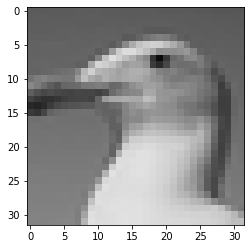

In [27]:
image_og = Image.open(imageNames[imageNum1]).convert('LA')
image_og_small = resizeimage.resize_cover(image_og, [32, 32])
plt.imshow(image_og_small, cmap='gray')

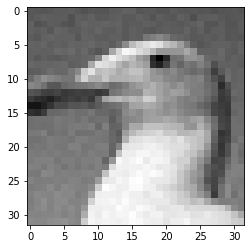

In [23]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 1)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

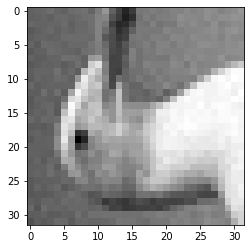

In [28]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 2)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

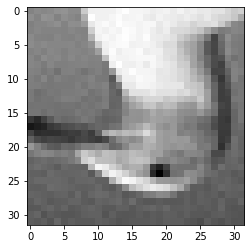

In [29]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 3)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

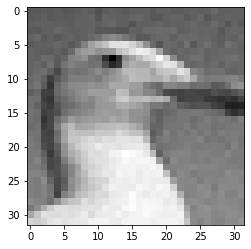

In [30]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 4)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

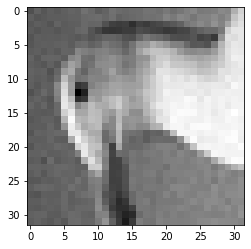

In [31]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 5)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

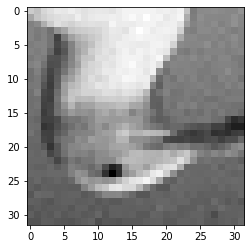

In [32]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 6)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

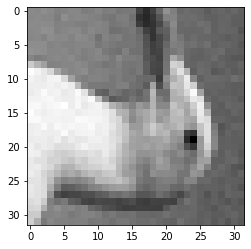

In [33]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 7)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

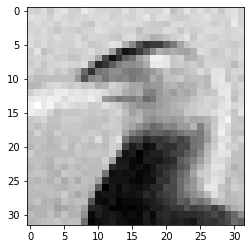

In [34]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 8)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

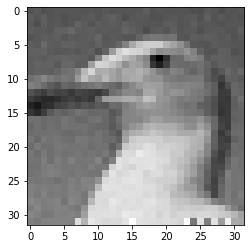

In [35]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 9)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

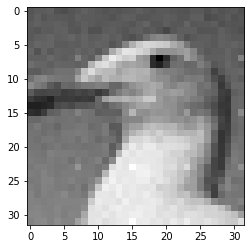

In [36]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 10)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

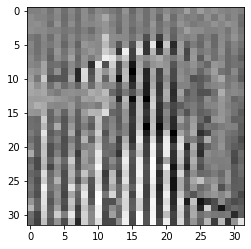

In [37]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 11)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

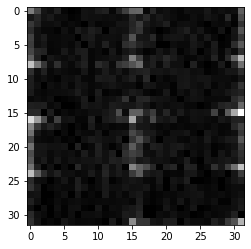

In [38]:
(anc_bw, img_bw, anc2_bw, c_bw, qc) = enc_img_bw_mod(image1, 12)
result_bw = execute(qc, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result = decode_image_bw(result_bw, qc, num_of_shots, w, h)
plt.imshow(img_result, cmap='gray')

In [50]:
num_of_shots = 1024*1024*8

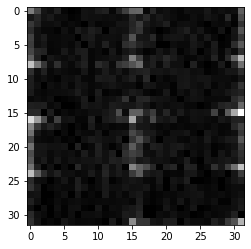

In [51]:
(anc_col, img_col, anc2_col, c_col, qc_col) = enc_img_col_mod(image2, 1)
result_col = execute(qc_col, backend, shots=num_of_shots, backend_options={"fusion_enable":True}).result()
img_result_col = decode_image_col(result_col, qc_col, num_of_shots, w, h)
img_result_col = img_result_col[:,:,1:4]
plt.imshow(img_result, cmap='gray')

In [ ]:
genimg_rgb = genimg_col[:,:,1:4]

In [ ]:
plt.imshow(genimg_rgb, cmap='gray')

In [ ]:
plt.imshow(genimg2, cmap='gray', vmin=0, vmax=255)
#plt.savefig('gen_'+str(imageNum1)+'.png')
plt.show()

In [ ]:
from numpy.fft import fft2, fftshift, ifftshift, ifft2
fft_new = fftshift(fft2(image1.reshape(32,32)))
img_ff = np.log(np.abs(fft_new))
plt.imshow(img_ff, cmap='gray')
#plt.savefig('gen_'+str(imageNum1)+'.png')
plt.show()

In [ ]:
from IPython.display import Image as show_img
show_img(filename='Pic.jpg')
#show_img(filename='Pic2.jpg')

In [ ]:
from scipy.signal import convolve2d
def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

In [ ]:
im = load_image(imageNames[imageNum1])
im = im.mean(axis=2) # convert to grayscale
show_image(im/2)

In [ ]:
delta_filt = np.array([1,-1]).reshape(1,2)
plt.imshow(convolve2d(im, delta_filt), cmap='gray')

In [ ]:

image = imread('images.jpeg')
print(image.shape)
plt.imshow(image, cmap='gray')

In [ ]:
from qiskit import IBMQ
IBMQ.save_account('d6b8341cf93840fcc1102abcda046ffed464d0d10c968ea9ebcedcb76044fe3732c7bed54e2b697fd4c8f8ed42676775f341d05509d59c157a7ebd410630e6c2',overwrite=True)

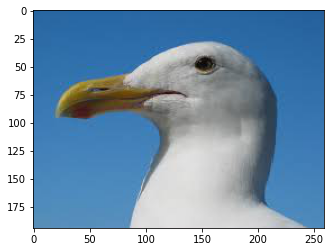

In [53]:
image2 = imread(imageNames[imageNum2])
image2 = Image.open(imageNames[imageNum2])
img = image2.resize((32,32), resample=Image.NEAREST)
#im = image2.load()
plt.imshow(image2)
#print(im[2,2])
#print(img.size)
#image2 = resizeimage.resize_cover(image2, [32, 32,3])